# 10-test-stl.ipynb

This notebook performs the segmentation workflow adapted for the compressed F50 sand experiment and adds a step to convert the segmented voxels to tri-meshes to be saved as STLs.

# Import packages

In [4]:
# Standard library imports
from pathlib import Path
import sys
# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
# Local module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
import segment
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load 3D data

Passing `slice_crop`, `row_crop`, and `col_crop` to only load part of the dataset

In [5]:
# Load images as 3D array from a directory containing images
imgs, scan_name = segment.load_images(
    Path(module_path) / r'data\SandComp4_18_22\NoComptiff',
    slice_crop=[75, 175], 
    row_crop=[450, 600], 
    col_crop=[100, 250],
    return_3d_array=True,
    convert_to_float=True,
    also_return_dir_name=True,
    file_suffix='tiff'
)
print(f'Images loaded as 3D array: {imgs.shape}')

Images loaded as 3D array: (100, 150, 150)


# Binarize data

In [6]:
imgs_binarized, thresh_vals = segment.binarize_multiotsu(imgs, n_otsu_classes=2)

# Segment Data

In [7]:
segment_dict = segment.watershed_segment(
    imgs_binarized, 
    min_peak_distance=7, 
    return_dict=True
)

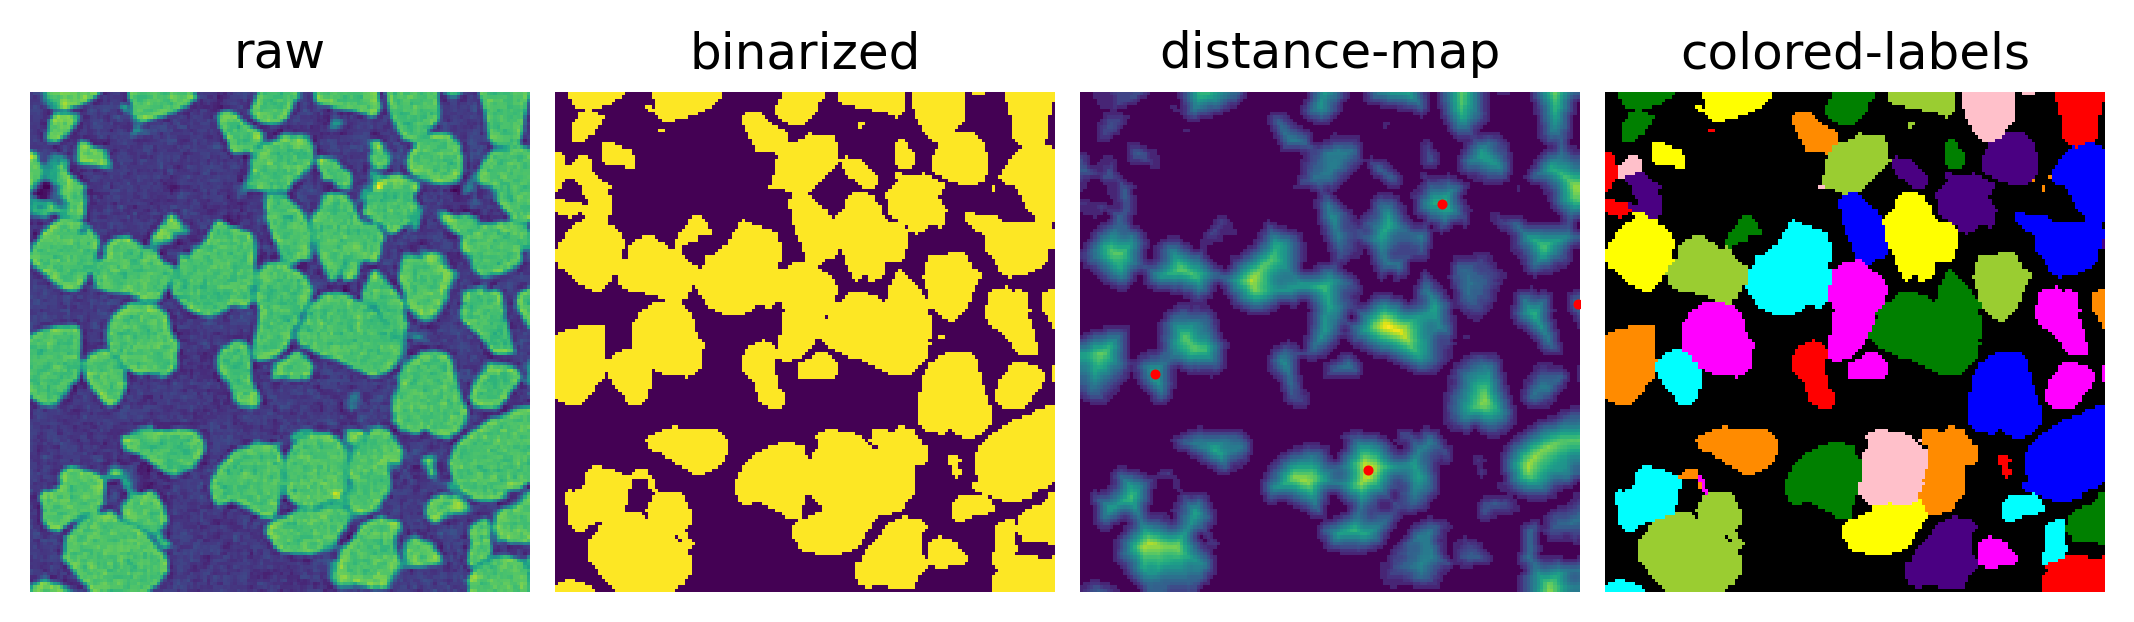

In [8]:
fig, axes = segment.plot_segment_steps(imgs, segment_dict, 55)
plt.show()

## Save STL for each grain

In [27]:
def save_as_stl_files(
    segment_dict, 
    dir_name, 
    save_dir_parent_path, 
    n_particle_label_digits=5
):
    save_dir_parent_path = Path(save_dir_parent_path)
    save_dir_path = Path(save_dir_parent_path / f'{dir_name}_STLs')
    if save_dir_path.exists():
        raise ValueError(f'Save directory already exists: {save_dir_path}')
    else:
        # Make directory to save STL files
        save_dir_path.mkdir()
    n_particles = np.max(segment_dict['integer-labels'])
    print(f'Saving {n_particles} STL file(s)...')
    # Start iteration at label 1 because 0 is background
    # End iteration at n_particles + 1 to include max label
    for particle_i in range(1, n_particles + 1):
        # Isolate particle with label particle_i
        isolated_voxels = segment.isolate_particle(segment_dict, particle_i)
        # Use marching cubes to obtain the surface mesh of these ellipsoids
        verts, faces, normals, values = measure.marching_cubes(isolated_voxels) 
        fn = f'{dir_name}-{str(particle_i).zfill(n_particle_label_digits)}.stl'
        save_path = Path(save_dir_path / fn)
        segment.save_stl(verts, faces, save_path, suppress_save_message=True)
    print(f'{particle_i} STL file(s) saved: {save_dir_path}')

save_as_stl_files(segment_dict, scan_name, Path(module_path) / 'results')

243 STL file(s) saved: c:\Users\gusb\Research\mhe-analysis\results\NoComptiff_STLs


## Load STL file and plot in 3D

Plotting STL: NoComptiff-00032.stl


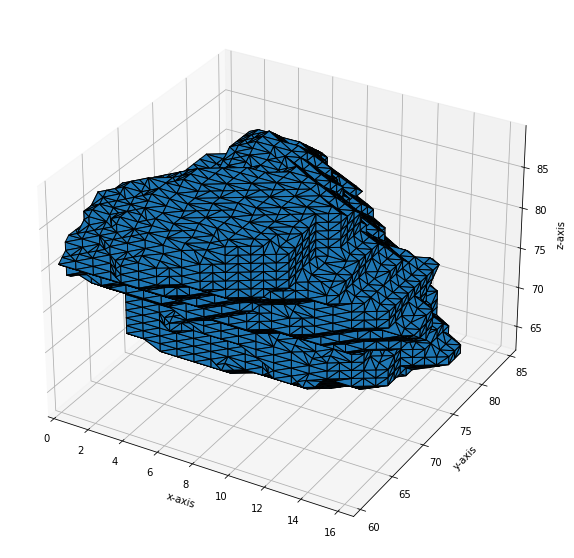

In [113]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from stl import mesh


def plot_stl(stl_path, zoom=True):
    stl_path = Path(stl_path)
    # If stl_path is a directory, choose a random file from inside
    if stl_path.is_dir():
        stl_path_list = [path for path in Path(stl_dir_path).glob('*.stl')]
        random_i = np.random.randint(0, len(stl_path_list))
        stl_path = stl_path_list[random_i]
        print(f'Plotting STL: {stl_path.name}')
    # Load the STL files and add the vectors to the plot
    stl_mesh = mesh.Mesh.from_file(stl_path)
    mpl_mesh = Poly3DCollection(stl_mesh.vectors)
    mpl_mesh.set_edgecolor('black')
    # Display resulting triangular mesh using Matplotlib
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.add_collection3d(mpl_mesh)
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    if zoom:
        # stl_mesh.vectors is Mx3x3 array (M 2D (3x3) arrays: [x, y, z]), 
        # Transpose (array.T) is 3x3xM array (3 2D (3xM) arrays: [x], [y], [z])
        ax.set_xlim(np.min(stl_mesh.vectors.T[0]), np.max(stl_mesh.vectors.T[0]))
        ax.set_ylim(np.min(stl_mesh.vectors.T[1]), np.max(stl_mesh.vectors.T[1]))
        ax.set_zlim(np.min(stl_mesh.vectors.T[2]), np.max(stl_mesh.vectors.T[2]))
    return fig, ax

stl_dir_path = r'C:\Users\gusb\Research\mhe-analysis\results\NoComptiff_STLs'
fig, ax = plot_stl(stl_dir_path, zoom=True)
plt.show()